# Quora Question-pair classification

This competition is about modelling whether a pair of questions on Quora is asking the same question. For this problem we have about **400.000** training examples. Each row consists of two sentences and a binary label that indicates to us whether the two questions were the same or not.

Inspired by this nice [kernel](https://www.kaggle.com/arthurtok/d/mcdonalds/nutrition-facts/super-sized-we-macdonald-s-nutritional-metrics) from [Anisotropic](https://www.kaggle.com/arthurtok) I've added a few interactive 2D and 3D scatter plots also here.

To get an insight into how the duplicates evolve over the number of words in the questions, I've added a plotly animation that encodes number of words and word share similarity in a scatter plot.

Also added parallel coordinates plot with explanation on the encoded question pairs.

If you like this kernel, please upvote it :D, thanks!

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#print(check_output(["ls", "data"]).decode("utf-8"))

train_df = pd.read_csv("data/train.csv").fillna("")
test_df = pd.read_csv("data/test.csv").fillna("")
print("train_df:",train_df.shape)
print("test_df:",test_df.shape)

train_df: (404290, 6)
test_df: (2345796, 3)


So we have six columns in total one of which is the label.

In [14]:
train_df.head(5)
test_df.head(5)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


We have a fairly balanced dataset here.

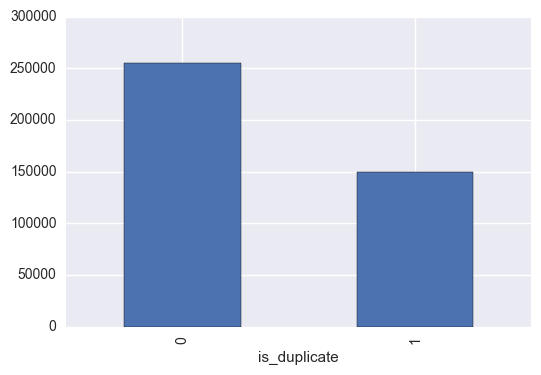

In [15]:
train_df.groupby("is_duplicate")['id'].count().plot.bar()

# Feature construction

We will now construct a basic set of features that we will later use to embed our samples with.

The first we will be looking at is rather standard TF-IDF encoding for each of the questions. In order to limit the computational complexity and storage requirements we will only encode the top terms across all documents with TF-IDF and also look at a subsample of the data.

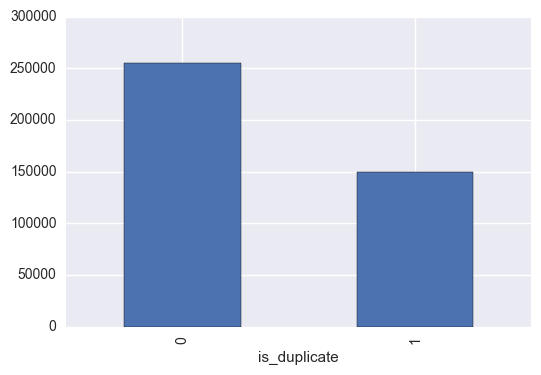

In [16]:
#dfs = train_df[0:2500]
#dfs.groupby("is_duplicate")['id'].count().plot.bar()
train_df.groupby("is_duplicate")['id'].count().plot.bar()

The subsample still has a very similar label distribution, ok to continue like that, without taking a deeper look how to achieve better sampling than just taking the first rows of the dataset.

Create a dataframe where the top 50% of rows have only question 1 and the bottom 50% have only question 2, same ordering per halve as in the original dataframe.

In [18]:
dfq1, dfq2 = train_df[['qid1', 'question1']], train_df[['qid2', 'question2']]
dfq1.columns = ['qid1', 'question']
dfq2.columns = ['qid2', 'question']

# merge two two dfs, there are two nans for question
dfqa = pd.concat((dfq1, dfq2), axis=0).fillna("")
nrows_for_q1 = dfqa.shape[0]/2
print(dfqa.shape)
dfqa.tail()

(808580, 3)


,qid1,qid2,question
404285,,379845,How many keywords are there in PERL Programmin...
404286,,155606,Is it true that there is life after death?
404287,,537929,What's this coin?
404288,,537931,I am having little hairfall problem but I want...
404289,,537933,What is it like to have sex with your cousin?


In [19]:
print(dfq1.shape)
print(dfq2.shape)

(404290, 2)
(404290, 2)


stopword

In [20]:
from nltk.corpus import stopwords
stops= stopwords.words("english")

from nltk.corpus import sinica_treebank
print(sinica_treebank.words())

['一', '友情', '嘉珍', '和', '我', '住在', '同一條', '巷子', '我們', ...]


Transform questions by TF-IDF.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
mq1 = TfidfVectorizer(max_features = 256,stop_words='english').fit_transform(dfqa['question'].values)
mq1.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [22]:
print(mq1.toarray().shape )
mq1[::2]

(808580, 256)


<404290x256 sparse matrix of type '<class 'numpy.float64'>'
	with 704377 stored elements in Compressed Sparse Row format>

Since we are looking at pairs of data, we will be taking the difference of all question one and question two pairs with this. This will result in a matrix that again has the same number of rows as the subsampled data and one vector that describes the relationship between the two questions.

In [23]:
diff_encodings = mq1[::2] - mq1[1::2]#question1与question2做差
diff_encodings

<404290x256 sparse matrix of type '<class 'numpy.float64'>'
	with 1396397 stored elements in Compressed Sparse Row format>

In [24]:
print(dfqa['question'].values.shape)
print(diff_encodings.toarray().shape )
dfqa['question'].values

(808580,)
(404290, 256)


array(['What is the step by step guide to invest in share market in india?',
       'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
       'How can I increase the speed of my internet connection while using a VPN?',
       ..., "What's this coin?",
       'I am having little hairfall problem but I want to use hair styling product. Which one should I prefer out of gel, wax and clay?',
       'What is it like to have sex with your cousin?'], dtype=object)

In [25]:
from pandas import DataFrame
temp = DataFrame(diff_encodings.toarray())
temp#非常稀疏，所以用tsne进行降维处理

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,-0.722112
6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
7,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000


# 3D t-SNE embedding

We will use t-SNE to embed the TF-IDF vectors in three dimensions and create an interactive scatter plot with them.

In [29]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=200,
    verbose=2,
    angle=0.5
).fit_transform(diff_encodings.toarray())

[t-SNE] Computing pairwise distances...


MemoryError: 

In [28]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = dfs['is_duplicate'].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='test')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# 2D t-SNE

In [30]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=200,
    verbose=2,
    angle=0.5
).fit_transform(diff_encodings.toarray())

[t-SNE] Computing pairwise distances...


MemoryError: 

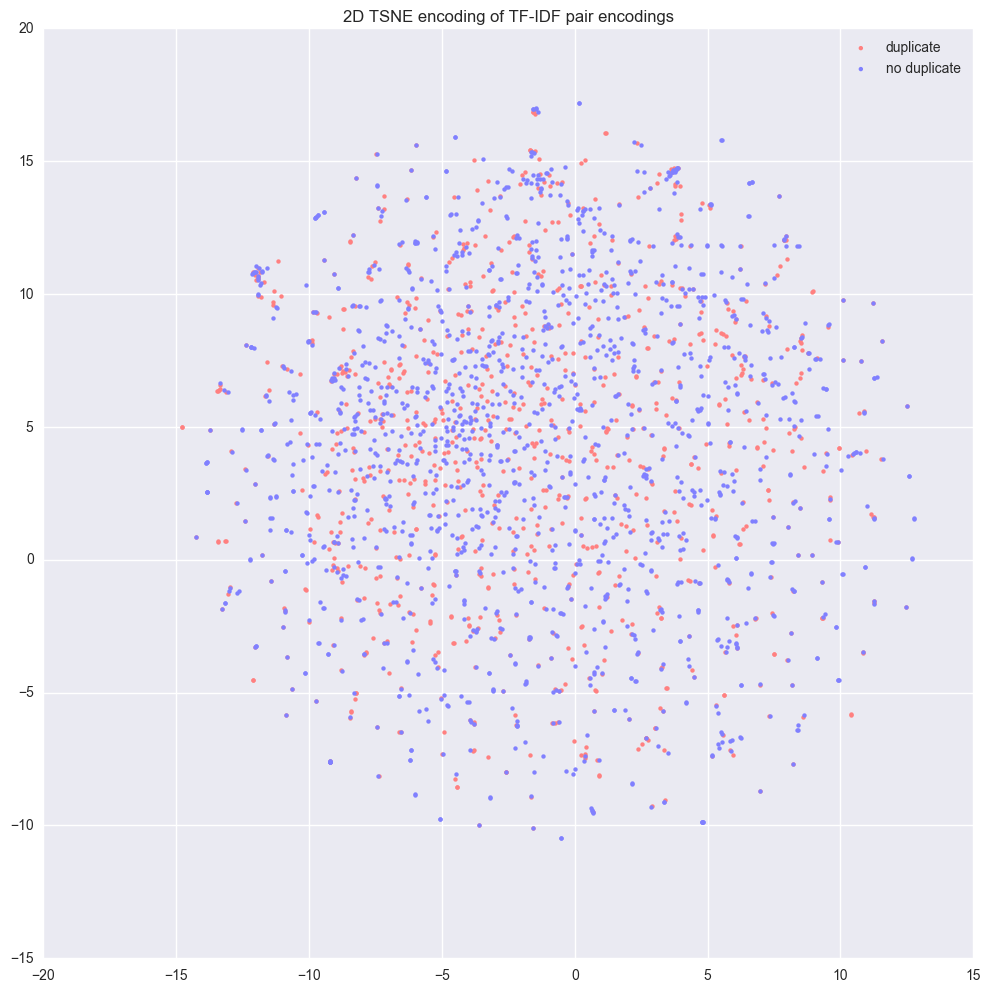

In [30]:
alpha = 0.5
plt.figure(figsize=(12,12))
tsne_t = tsne[np.where(dfs['is_duplicate'] == 1), :][0]
plt.scatter(tsne_t[:, 0], tsne_t[:, 1], s=10, lw = 0, color=[1.0, alpha, alpha])
tsne_t = tsne[np.where(dfs['is_duplicate'] == 0), :][0]
plt.scatter(tsne_t[:, 0], tsne_t[:, 1], s=10, lw = 0, color=[alpha, alpha, 1.0])
plt.legend(['duplicate', 'no duplicate'])

plt.title('2D TSNE encoding of TF-IDF pair encodings')

## Feature EDA

Let us now construct a few features

* character length of questions 1 and 2
* number of words in question 1 and 2
* normalized word share count.

We can then have a look at how well each of these separate the two classes.

In [2]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


df['word_share'] = df.apply(normalized_word_share, axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,0.100000


The distributions for normalized word share have some overlap on the far right hand side, meaning there are quite a lot of questions with high word similarity but are both duplicates and non-duplicates.

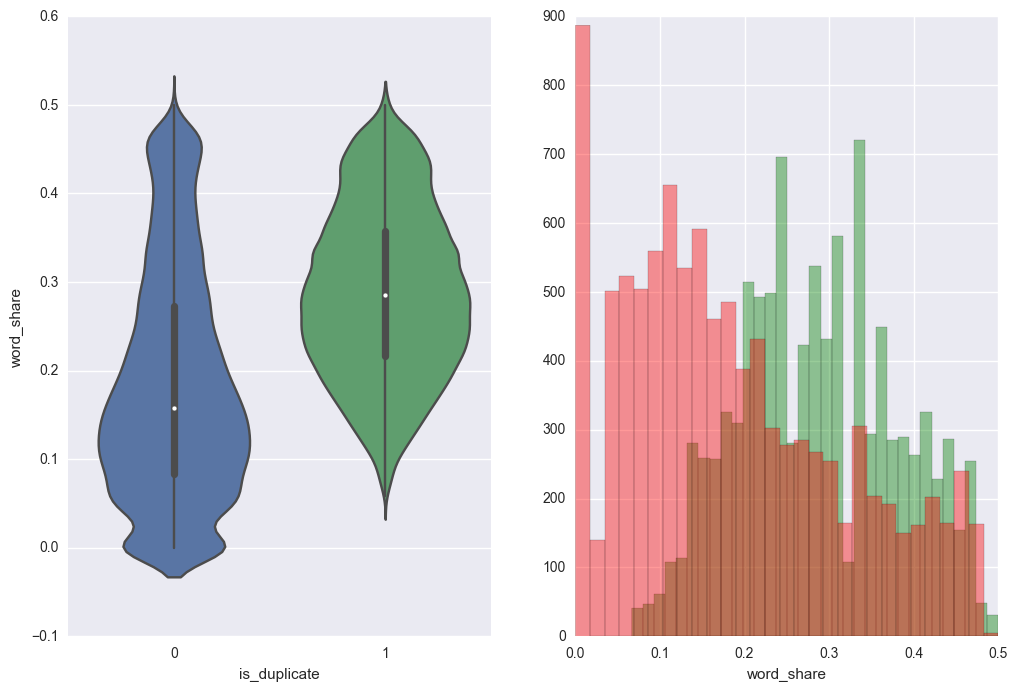

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:50000])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:10000], kde=False, color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:10000],kde=False, color = 'red')

Scatter plot of question pair character lengths where color indicates duplicates and the size the word share coefficient we've calculated earlier.

In [12]:
df_subsampled = df[0:2000]

trace = go.Scatter(
    y = df_subsampled['q2len'].values,
    x = df_subsampled['q1len'].values,
    mode='markers',
    marker=dict(
        size= df_subsampled['word_share'].values * 60,
        color = df_subsampled['is_duplicate'].values,
        colorscale='Portland',
        showscale=True,
        opacity=0.5,
        colorbar = dict(title = 'duplicate')
    ),
    text = np.round(df_subsampled['word_share'].values, decimals=2)
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Scatter plot of character lengths of question one and two',
    hovermode= 'closest',
        xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title= 'Question 2 length',
        ticklen= 5,
        gridwidth= 2,
        showgrid=False,
        zeroline=False,
        showline=False,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterWords')

# Animation over average number of words

For that we will calculate the average number of words in both questions for each row.

In the end we want to have a scatter plot, just like the one above, but giving us one more dimension, in that case the average number of words in both questions. That will allow us to see the dependence on that variable. We also expect that as the number of words is increased, the character lengths of Q1 and Q2 will increase.

In [30]:
from IPython.display import display, HTML

df_subsampled['q_n_words_avg'] = np.round((df_subsampled['q1_n_words'] + df_subsampled['q2_n_words'])/2.0).astype(int)
print(df_subsampled['q_n_words_avg'].max())
df_subsampled = df_subsampled[df_subsampled['q_n_words_avg'] < 20]
df_subsampled.head()

34


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share,q_n_words_avg
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,0.434783,13
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,0.200000,10
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,0.166667,12
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.000000,10
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,0.100000,10


In [34]:
word_lens = sorted(list(df_subsampled['q_n_words_avg'].unique()))

In [40]:
# make figure
figure = {
    'data': [],
    'layout': {
        'title': 'Scatter plot of char lenghts of Q1 and Q2 (size ~ word share similarity)',
    },
    'frames': []#,
    #'config': {'scrollzoom': True}
}

# fill in most of layout
figure['layout']['xaxis'] = {'range': [0, 200], 'title': 'Q1 length'}
figure['layout']['yaxis'] = {
    'range': [0, 200],
    'title': 'Q2 length'#,
    #'type': 'log'
}
figure['layout']['hovermode'] = 'closest'

figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 300, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

In [43]:
sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Avg. number of words in both questions:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

In [44]:
# make data
word_len = word_lens[0]
dff = df_subsampled[df_subsampled['q_n_words_avg'] == word_len]
data_dict = {
    'x': list(dff['q1len']),
    'y': list(dff['q2len']),
    'mode': 'markers',
    'text': list(dff['is_duplicate']),
    'marker': {
        'sizemode': 'area',
        #'sizeref': 200000,
        'colorscale': 'Portland',
        'size': dff['word_share'].values * 120,
        'color': dff['is_duplicate'].values,
        'colorbar': dict(title = 'duplicate')
    },
    'name': 'some name'
}
figure['data'].append(data_dict)

In [45]:
# make frames
for word_len in word_lens:
    frame = {'data': [], 'name': str(word_len)}
    dff = df_subsampled[df_subsampled['q_n_words_avg'] == word_len]

    data_dict = {
        'x': list(dff['q1len']),
        'y': list(dff['q2len']),
        'mode': 'markers',
        'text': list(dff['is_duplicate']),
        'marker': {
            'sizemode': 'area',
            #'sizeref': 200000,
            'size': dff['word_share'].values * 120,
            'colorscale': 'Portland',
            'color': dff['is_duplicate'].values,
            'colorbar': dict(title = 'duplicate')
        },
        'name': 'some name'
    }
    frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [word_len],
        {
            'frame': {'duration': 300, 'redraw': False},
            'mode': 'immediate',
            'transition': {'duration': 300}
        }
     ],
     'label': word_len,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

In [46]:
figure['layout']['sliders'] = [sliders_dict]

In [50]:
py.iplot(figure)

PlotlyError: Invalid 'figure_or_data' argument. Plotly will not be able to properly parse the resulting JSON. If you want to send this 'figure_or_data' to Plotly anyway (not recommended), you can set 'validate=False' as a plot option.
Here's why you're seeing this error:

'frames' is not allowed in 'figure'

Path To Error: ['frames']

Valid attributes for 'figure' at path [] under parents []:

    ['data', 'layout']

Run `<figure-object>.help('attribute')` on any of the above.
'<figure-object>' is the object at []

# Parallel Coordinates

We now want to get another perspective on high dimensional data, such as the TF-IDF encoded questions. For that purpose I'll encode the concatenated questions into a set of N dimensions, s.t. each row in the dataframe then has one N dimensional vector associated to it.
With this we can then have a look at how these coordinates (or TF-IDF dimensions) vary by label.

There are many EDA methods to visualize high dimensional data, I'll show parallel coordinates here.

To make a nice looking plot, I've chosen N to be quite small, much smaller actually than you would encode it in a machine learning algorithm.

E:\Anaconda2\envs\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



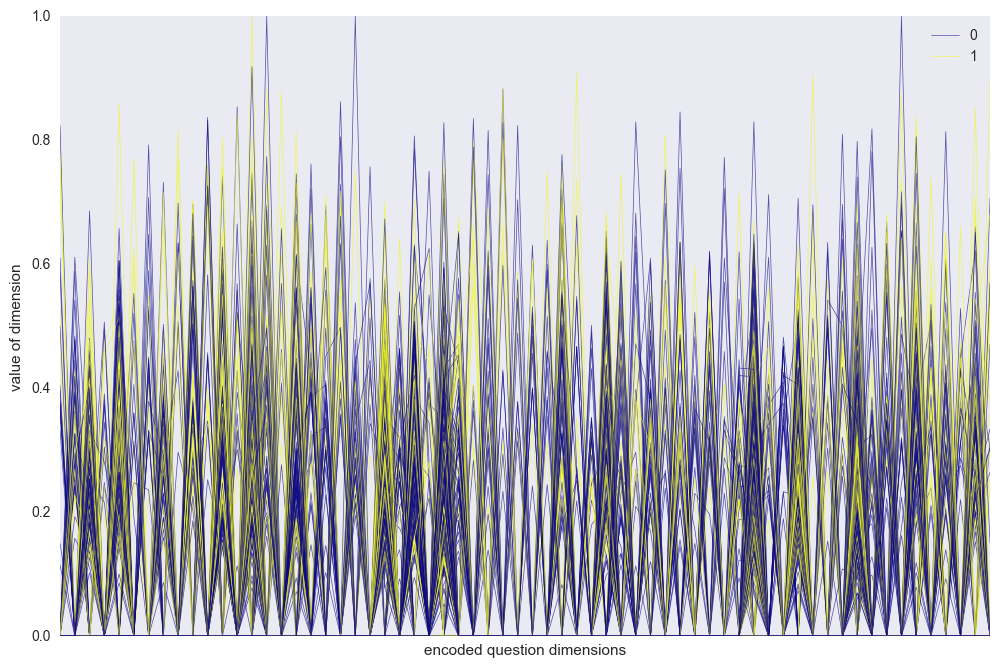

In [48]:
from pandas.tools.plotting import parallel_coordinates

df_subsampled = df[0:500]

N = 64

#encoded = HashingVectorizer(n_features = N).fit_transform(df_subsampled.apply(lambda row: row['question1']+' '+row['question2'], axis=1).values)
encoded = TfidfVectorizer(max_features = N).fit_transform(df_subsampled.apply(lambda row: row['question1']+' '+row['question2'], axis=1).values)
# generate columns in the dataframe for each of the 32 dimensions
cols = ['hashed_'+str(i) for i in range(encoded.shape[1])]
for idx, col in enumerate(cols):
    df_subsampled[col] = encoded[:,idx].toarray()

plt.figure(figsize=(12,8))
kws = {
    'linewidth': 0.5,
    'alpha': 0.7
}
parallel_coordinates(
    df_subsampled[cols + ['is_duplicate']],
    'is_duplicate',
    axvlines=False, colormap=plt.get_cmap('plasma'),
    **kws
)
#plt.grid(False)
plt.xticks([])
plt.xlabel("encoded question dimensions")
plt.ylabel("value of dimension")

In the parallel coordinates we can see that there are some dimensions that have high TF-IDF features values for duplicates and others high values for non-duplicates.

# Question character length correlations by duplication label

The pairplot of character length of both questions by duplication label is showing us that, duplicated questions seem to have a somewhat similar amount of characters in them.

Also we can see something quite intuitive, that there is rather strong correlation in the number of words and the number of characters in a question.

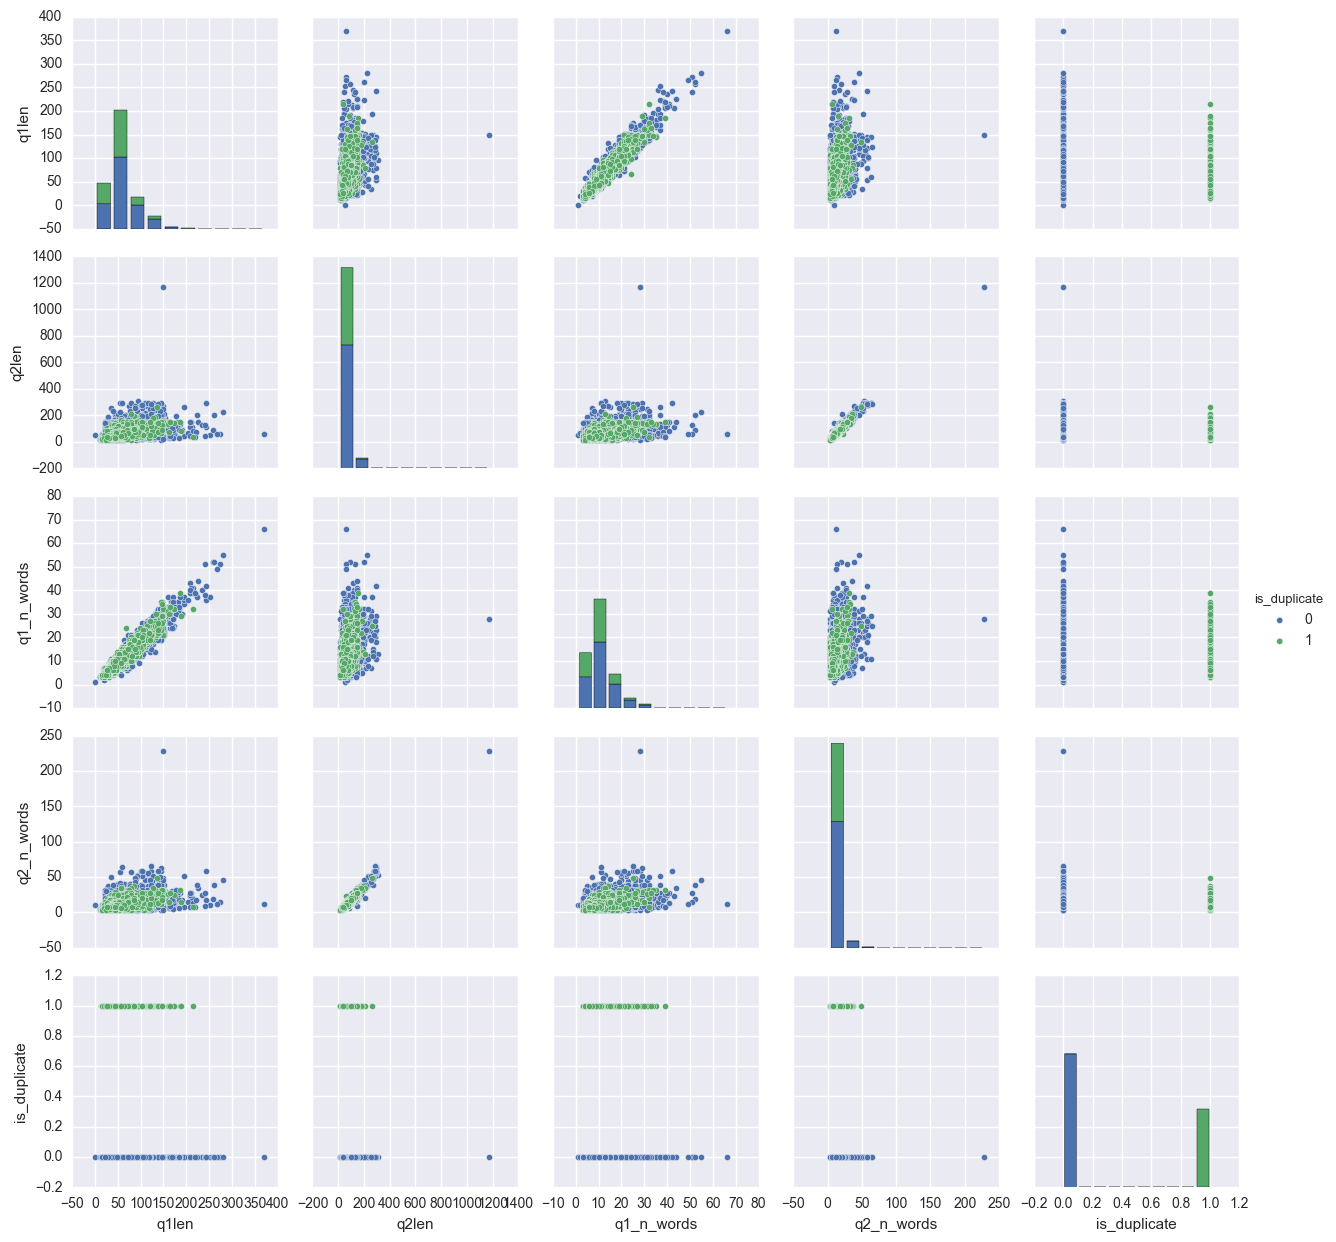

In [15]:
n = 10000
sns.pairplot(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'is_duplicate']][0:n], hue='is_duplicate')

In [51]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Model starter

Train a model with the basic feature we've constructed so far.